## Creating a Realtime Object detection model

## 1. Setup and Get Data

In [6]:
!pip install labelme 'opencv-python' matplotlib albumentations tensorflow tensorflow-gpu 

  Using cached labelme-5.0.1.tar.gz (1.5 MB)
  Preparing metadata (setup.py) ... done
  Using cached opencv_python-4.5.5.64-cp37-abi3-macosx_11_0_arm64.whl (29.9 MB)
  Using cached albumentations-1.1.0-py3-none-any.whl (102 kB)
ERROR: Could not find a version that satisfies the requirement tensorflow (from versions: none)
ERROR: No matching distribution found for tensorflow


https://www.milindsoorya.com/blog/installing-tensorflow-on-m1-macbook-air-with-gpu

## 1.2 Collect Images Using OpenCV

In [2]:
import os
import time
import uuid
import cv2

In [8]:
IMAGES_PATH = os.path.join('data', 'images')
number_images = 20

In [10]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
        
cap.release()
cv2.destroyAllWindows()

## 1.3 Annotate Images with LabelMe

In [ ]:
!labelme 

## 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [3]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [12]:
# Avoid OOM errors by setting GPU Memomry Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Metal device set to: Apple M1


2022-05-28 13:17:46.006540: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-28 13:17:46.007042: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


True

In [15]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 2.3 Load Images into TF Data Pipeline

In [19]:
images = tf.data.Dataset.list_files('data/images/*.jpg', shuffle=False)

In [20]:
images.as_numpy_iterator().next()

b'data/images/12cc47c1-de73-11ec-a385-c0b6f9f8e64c.jpg'

In [21]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [22]:
images = images.map(load_image)

In [23]:
images.as_numpy_iterator().next()

2022-05-28 16:28:53.234592: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


array([[[113, 117, 155],
        [112, 116, 154],
        [111, 115, 153],
        ...,
        [ 85,  87, 125],
        [ 84,  87, 122],
        [ 81,  84, 119]],

       [[111, 115, 153],
        [110, 114, 152],
        [110, 114, 152],
        ...,
        [ 86,  88, 126],
        [ 85,  88, 123],
        [ 83,  86, 121]],

       [[108, 113, 151],
        [108, 113, 151],
        [109, 114, 152],
        ...,
        [ 86,  88, 126],
        [ 86,  88, 126],
        [ 88,  90, 128]],

       ...,

       [[ 82,  67, 108],
        [ 82,  67, 108],
        [ 72,  60, 100],
        ...,
        [  9,   9,  21],
        [  9,   9,  21],
        [  8,   8,  20]],

       [[ 72,  57,  98],
        [ 78,  63, 104],
        [ 72,  57,  98],
        ...,
        [  9,   9,  21],
        [  9,   9,  21],
        [  8,   8,  20]],

       [[ 71,  56,  97],
        [ 81,  66, 107],
        [ 79,  64, 105],
        ...,
        [  9,   9,  21],
        [  9,   9,  21],
        [  9,   9,  21]]

In [24]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

## 2.4 View Raw Images with Matplotlib

In [46]:
image_generator = images.batch(4).as_numpy_iterator()

In [47]:
plot_images = image_generator.next()

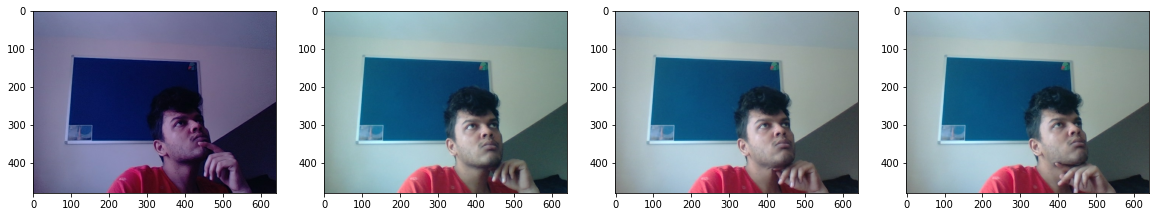

In [48]:
fig, ax = plt.subplots(ncols=4, figsize=(20, 20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data

### 3.1 Split Data to Train and test Dataset

In [50]:
import splitfolders
splitfolders.ratio('data', output="output", seed=1337, ratio=(.8, 0.1,0.1)) 

Copying files: 128 files [00:00, 1202.88 files/s]


## 3.2 Move the Matching Labels

In [51]:
for folder in ['train', 'test', 'val']:
    for file in os.listdir(os.path.join('output', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('output', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Tranform Pipeline

In [56]:
import albumentations as alb

In [57]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450),
                        alb.HorizontalFlip(p=0.5),
                        alb.RandomBrightnessContrast(p=0.2),
                        alb.RandomGamma(p=0.2),
                        alb.RGBShift(p=0.2),
                        alb.VerticalFlip(p=0.5)],
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                 label_fields=['class_labels']))

### 4.2 Load and Test Image And Annotation with OpenCv and JSON

In [58]:
img = cv2.imread(os.path.join('output', 'train', 'images', '12cc47c1-de73-11ec-a385-c0b6f9f8e64c.jpg'))

In [59]:
img

array([[[155, 117, 113],
        [154, 116, 112],
        [153, 115, 111],
        ...,
        [126,  88,  86],
        [124,  86,  84],
        [121,  83,  81]],

       [[153, 115, 111],
        [153, 115, 111],
        [153, 115, 111],
        ...,
        [126,  88,  86],
        [125,  87,  85],
        [124,  86,  84]],

       [[151, 113, 109],
        [152, 114, 110],
        [152, 114, 110],
        ...,
        [126,  88,  86],
        [127,  89,  87],
        [129,  91,  89]],

       ...,

       [[108,  67,  82],
        [109,  68,  83],
        [100,  59,  74],
        ...,
        [ 21,   9,   9],
        [ 21,   9,   9],
        [ 21,   9,   9]],

       [[ 99,  58,  73],
        [104,  63,  78],
        [ 99,  58,  73],
        ...,
        [ 21,   9,   9],
        [ 21,   9,   9],
        [ 21,   9,   9]],

       [[ 98,  57,  72],
        [108,  67,  82],
        [105,  64,  79],
        ...,
        [ 21,   9,   9],
        [ 21,   9,   9],
        [ 21,   9,   9]]

In [62]:
with open(os.path.join('output', 'train', 'labels', '12cc47c1-de73-11ec-a385-c0b6f9f8e64c.json'), 'r') as f:
    label = json.load(f)

In [65]:
label['shapes'][0]

{'label': 'face',
 'points': [[300.3188405797102, 206.24637681159422],
  [477.6135265700484, 399.00000000000006]],
 'group_id': None,
 'shape_type': 'rectangle',
 'flags': {}}

### 4.3 Extract Coordinates and Rescale to Image Resolution

In [66]:
## TODO - Try dictionary
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [67]:
coords

[300.3188405797102, 206.24637681159422, 477.6135265700484, 399.00000000000006]

In [69]:
# Divide by image dimesions - https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/
coords = list(np.divide(coords, [640,480,640,480]))

In [70]:
coords

[0.4692481884057972,
 0.4296799516908213,
 0.7462711352657007,
 0.8312500000000002]

### Apply Augmentations and View Results

In [71]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [72]:
augmented

{'image': array([[[133,  95,  95],
         [134,  96,  94],
         [135,  97,  95],
         ...,
         [172, 131, 128],
         [172, 131, 128],
         [171, 131, 126]],
 
        [[133,  95,  95],
         [133,  95,  93],
         [134,  96,  94],
         ...,
         [171, 130, 127],
         [171, 130, 127],
         [170, 130, 125]],
 
        [[133,  95,  95],
         [132,  94,  92],
         [133,  95,  93],
         ...,
         [171, 130, 127],
         [171, 130, 127],
         [170, 130, 125]],
 
        ...,
 
        [[ 46,  18,  37],
         [ 47,  18,  34],
         [ 47,  18,  34],
         ...,
         [156, 118, 114],
         [156, 118, 114],
         [157, 119, 115]],
 
        [[ 40,  10,  29],
         [ 41,  12,  28],
         [ 42,  13,  29],
         ...,
         [156, 118, 114],
         [156, 118, 114],
         [157, 119, 115]],
 
        [[ 42,  12,  31],
         [ 51,  19,  38],
         [ 51,  19,  36],
         ...,
         [157, 119,

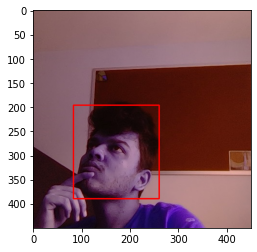

In [73]:
cv2.rectangle(augmented['image'],
             tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]). astype(int)),
             tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]). astype(int)),
              (255, 0, 0), 2)

plt.imshow(augmented['image'])

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [77]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('output', partition, 'images')):
        img = cv2.imread(os.path.join('output', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('output', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

x_max is less than or equal to x_min for bbox [0.34621074879227054, 0.8624496779388084, 0.06767814009661836, 0.33910024154589374, 'face'].


### 5.2 Load Augmented Images to Tensorflow Dataset

In [79]:
train_images = tf.data.Dataset.list_files('aug_data/train/images/*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [80]:
test_images = tf.data.Dataset.list_files('aug_data/test/images/*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [81]:
val_images = tf.data.Dataset.list_files('aug_data/val/images/*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [ ]:
train_images.as_numpy_iterator().next()

## Prepare Labels

### 6.1 Build Label Loading Function

In [83]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [84]:
train_labels = tf.data.Dataset.list_files('aug_data/train/labels/*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

test_labels = tf.data.Dataset.list_files('aug_data/test/labels/*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

val_labels = tf.data.Dataset.list_files('aug_data/val/labels/*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [85]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.323  , 0.12445, 0.717  , 0.5527 ], dtype=float16))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [87]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2880, 2880, 360, 360, 360, 360)

### 7.2 Create Final Datasets (Images/Labels)

In [88]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [89]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [90]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

### 7.3 View Images and Annotations

In [94]:
data_samples = train.as_numpy_iterator()

In [95]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


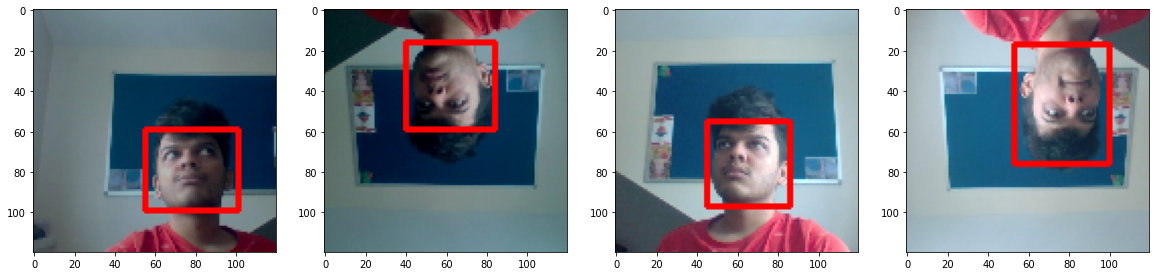

In [96]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

## 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [97]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [98]:
vgg = VGG16(include_top=False)

58900480/58889256 [==============================] - 42s 1us/step


In [101]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build Instanace of Network

In [105]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [0]], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.2751 , 0.4429 , 0.709  , 0.8164 ],
        [0.4712 , 0.1065 , 0.898  , 0.569  ],
        [0.     , 0.647  , 0.08813, 1.     ],
        [0.1771 , 0.4912 , 0.5474 , 0.8745 ],
        [0.723  , 0.3271 , 1.     , 0.854  ],
        [0.2194 , 0.4646 , 0.59   , 0.8477 ],
        [0.     , 0.     , 0.     , 0.     ]], dtype=float16))

From the training sample we can see that we have two types of inputs. 

1. Classification input - the values are either 0 or 1 and tells if the inout contain a face
2. Bounding box input - tells where the identified face is by using a bounding box

when creating a model we are using the above two informations.

Note - Sigmoid activation: Given any input it maps the output into [0, 1]

In [103]:
def build_model():
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    
    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [106]:
facetracker = build_model()

In [107]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [109]:
X, y = train.as_numpy_iterator().next()

In [111]:
X.shape

(8, 120, 120, 3)

In [113]:
classes, coords = facetracker.predict(X)

2022-05-29 11:57:58.306762: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [114]:
classes, coords

(array([[0.37292892],
        [0.46777448],
        [0.49955705],
        [0.52121913],
        [0.3459164 ],
        [0.36708272],
        [0.43682548],
        [0.39753905]], dtype=float32),
 array([[0.5820921 , 0.6504537 , 0.217337  , 0.3205825 ],
        [0.46558997, 0.65127933, 0.25088048, 0.38428402],
        [0.49697205, 0.5618216 , 0.24835381, 0.3696801 ],
        [0.50236994, 0.5525457 , 0.14568287, 0.30526423],
        [0.5229742 , 0.62171113, 0.14847744, 0.23259042],
        [0.5165769 , 0.6493773 , 0.19718163, 0.2854661 ],
        [0.49794006, 0.6153208 , 0.21749757, 0.31612566],
        [0.4839151 , 0.5922824 , 0.20947556, 0.3455967 ]], dtype=float32))

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [115]:
len(train)

360

In [116]:
batches_per_epoch = len(train)
# Specifies by how much our learning rate decays as it goes through each epoch
lr_decay = (1./0.75 - 1)/batches_per_epoch

In [117]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [118]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [119]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [120]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.573682>

In [121]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.86304885>

In [122]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=9.573682>

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [123]:
class FaceTracker(Model): 
    def __init__(self, facetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = facetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [124]:
model = FaceTracker(facetracker)

In [125]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [126]:
logdir='logs'

In [127]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [128]:
hist = model.fit(train, epochs=10, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/10


2022-05-29 12:25:17.036284: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


360/360 [==============================] - ETA: 0s - total_loss: 0.3436 - class_loss: 0.0877 - regress_loss: 0.2997

2022-05-29 12:26:26.590151: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


360/360 [==============================] - 73s 185ms/step - total_loss: 0.3429 - class_loss: 0.0874 - regress_loss: 0.2992 - val_total_loss: 0.1285 - val_class_loss: 5.6381e-04 - val_regress_loss: 0.1283
Epoch 2/10
360/360 [==============================] - 69s 185ms/step - total_loss: 0.0992 - class_loss: 0.0205 - regress_loss: 0.0890 - val_total_loss: 0.0422 - val_class_loss: 7.8932e-05 - val_regress_loss: 0.0421
Epoch 3/10
360/360 [==============================] - 70s 187ms/step - total_loss: 0.0375 - class_loss: 0.0085 - regress_loss: 0.0333 - val_total_loss: 0.0792 - val_class_loss: 3.8939e-04 - val_regress_loss: 0.0790
Epoch 4/10
360/360 [==============================] - 70s 187ms/step - total_loss: 0.0250 - class_loss: 0.0059 - regress_loss: 0.0220 - val_total_loss: 0.0208 - val_class_loss: 5.0177e-05 - val_regress_loss: 0.0208
Epoch 5/10
360/360 [==============================] - 70s 187ms/step - total_loss: 0.0197 - class_loss: 0.0063 - regress_loss: 0.0165 - val_total_loss:

### 10.3 Plot Performance

In [129]:
hist.history

{'total_loss': [0.09636615216732025,
  0.026559071615338326,
  0.5143742561340332,
  0.011067119427025318,
  0.004274776205420494,
  0.008126148954033852,
  0.003148391842842102,
  0.009467377327382565,
  0.004610396455973387,
  0.002970477333292365],
 'class_loss': [0.0029442263767123222,
  0.002077524783089757,
  0.27938345074653625,
  0.0003650264989119023,
  0.00026857713237404823,
  0.00038827641401439905,
  7.567837019450963e-05,
  0.00015413515211548656,
  0.00013689656043425202,
  0.00014412665041163564],
 'regress_loss': [0.09489403665065765,
  0.025520309805870056,
  0.3746825158596039,
  0.010884606279432774,
  0.004140487872064114,
  0.007932011038064957,
  0.0031105526722967625,
  0.009390309453010559,
  0.0045419479720294476,
  0.002898413920775056],
 'val_total_loss': [0.12854570150375366,
  0.04217047244310379,
  0.07916811853647232,
  0.020783474668860435,
  0.08648821711540222,
  0.054499879479408264,
  0.049733877182006836,
  0.063514344394207,
  0.0164648424834013,


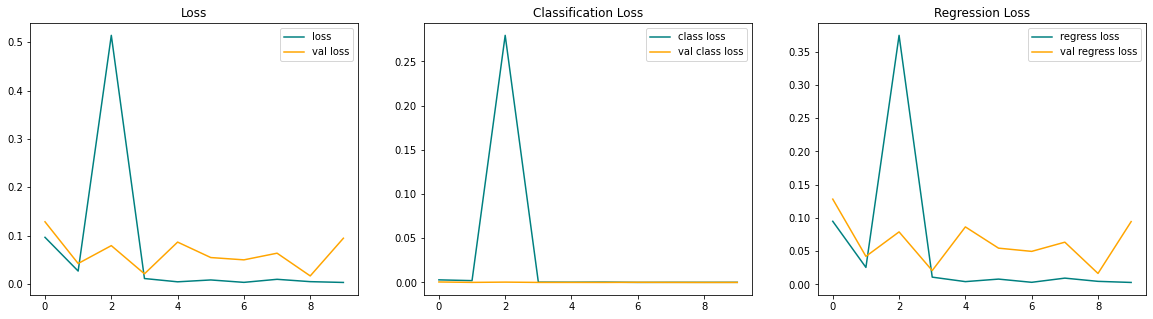

In [130]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

## 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [131]:
test_data = test.as_numpy_iterator()

In [144]:
test_sample = test_data.next()

In [145]:
yhat = facetracker.predict(test_sample[0])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


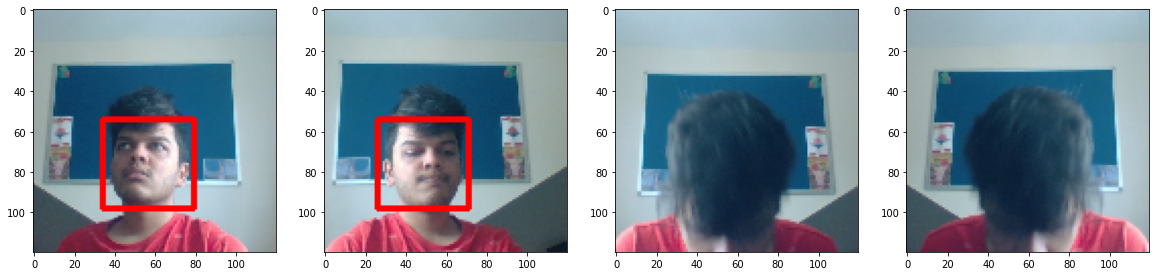

In [146]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [2]:
from tensorflow.keras.models import load_model

In [152]:
facetracker.save('facetracker.h5')

In [3]:
facetracker = load_model('facetracker.h5')

Metal device set to: Apple M1


2022-05-29 12:56:33.476747: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-29 12:56:33.476917: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### 11.3 Real Time Detection

In [7]:
import cv2
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

In [11]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.8: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()  